In [14]:
#%%

from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
text = "The majestic giraffe, with its towering height and distinctive long neck, roams the savannas of Africa. These gentle giants use their elongated tongues to pluck leaves from the tallest trees, making them well-adapted to their environment. Their unique coat patterns, much like human fingerprints, are unique to each individual."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input, output_hidden_states=True)

In [15]:
# %%

token_ids = encoded_input['input_ids']
token_texts = [tokenizer.decode([token_id]) for token_id in token_ids[0]]

In [16]:
# %%

features = output.last_hidden_state.squeeze(0)
print(features.shape, len(token_texts))

torch.Size([66, 768]) 66


In [30]:
# %%

from ncut_pytorch import NCUT, rgb_from_tsne_3d

features = features.detach()
eigenvectors, eigenvalues = NCUT(num_eig=10, device="cpu").fit_transform(features)
X_3d, rgb = rgb_from_tsne_3d(eigenvectors, perplexity=30) # perplexity is a hyperparameter for t-SNE
rgb = rgb.numpy()
print("X_3d shape:", X_3d.shape)
print("rgb shape:", rgb.shape)
print("token_texts length:", len(token_texts))

X_3d shape: (66, 3)
rgb shape: (66, 3)
token_texts length: 66


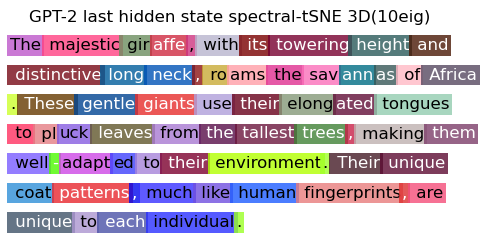

In [31]:
# %%

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 2.5))

# Define the colors
colors = [mcolors.rgb2hex(rgb[i]) for i in range(len(token_texts))]

# Split the sentence into words
words = token_texts


y_pos = 0.9
x_pos = 0.0
max_word_length = max(len(word) for word in words)
for word, color in zip(words, colors):
    if word == '<|begin_of_text|>':
        word = '<SoT>'
        y_pos -= 0.05
        x_pos = 0.0

    
    text_color = 'black' if sum(mcolors.hex2color(color)) > 1.3 else 'white'  # Choose text color based on background color
    # text_color = 'black'
    txt = ax.text(x_pos, y_pos, word, color=text_color, fontsize=12, bbox=dict(facecolor=color, alpha=0.8, edgecolor='none', pad=2))
    txt_width = txt.get_window_extent().width / (fig.dpi * fig.get_size_inches()[0])  # Calculate the width of the text in inches
    
    x_pos += txt_width * 1.1 + 0.01  # Adjust the spacing between words
    
    if x_pos > 0.97:
        y_pos -= 0.15
        x_pos = 0.0
    # break
        
# Remove the axis ticks and spines
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("GPT-2 last hidden state spectral-tSNE 3D(10eig)")
plt.tight_layout()
plt.show()